In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

sns.set(style="white")
%matplotlib inline

def rmse(y_test, y_pred):
      return np.sqrt(mean_squared_error(y_test, y_pred))

def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


In [2]:
df_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [3]:
df_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [4]:
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

size = len(list(df_train.columns))-1

# df_train.dropna(axis=1, inplace=True)
# f_columns = list(df_train.columns)
# size = len(f_columns)-1
# del f_columns[size]
# df_test = df_test[f_columns]
# df_train.head()

In [5]:
def preprocessing(df):
    simputer = SimpleImputer(strategy="most_frequent")
    
    df = df.replace(np.nan, 0).replace(np.inf, 1e+5).replace(-np.inf, -1e+5)
    for column in df.columns:
        if df[column].dtype.name == "object":
            df[column] = pd.Categorical(df[column]).codes

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num_cols = list(df.select_dtypes(include=numerics).columns)
    df[num_cols] = simputer.fit_transform(df[num_cols])
    return df

def normalization(df, norm):
    columns = df.columns
    return pd.DataFrame(norm.transform(df), columns=columns)

columns = df_train.columns
x_train = pd.DataFrame(df_train.to_numpy()[:, :size], columns=columns[:size])
y_train = df_train.to_numpy()[:, size:].ravel().astype(np.float64)

df_train = preprocessing(x_train).astype(np.int)
df_test = preprocessing(df_test).astype(np.int)

# norm = StandardScaler().fit(df_train)
# df_train = normalization(df_train, norm).astype(np.float64)
# df_test = normalization(df_test, norm).astype(np.float64)

# norm = MinMaxScaler().fit(df_train)
# df_train = normalization(df_train, norm).astype(np.float64)
# df_test = normalization(df_test, norm).astype(np.float64)

print(df_train.shape)
print(df_test.shape)
print(y_train.shape)

(1460, 79)
(1459, 79)
(1460,)


In [6]:
df_train.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65,8450,1,0,3,3,0,4,...,0,0,0,0,0,0,2,2008,8,4
1,20,3,80,9600,1,0,3,3,0,2,...,0,0,0,0,0,0,5,2007,8,4
2,60,3,68,11250,1,0,0,3,0,4,...,0,0,0,0,0,0,9,2008,8,4
3,70,3,60,9550,1,0,0,3,0,0,...,0,0,0,0,0,0,2,2006,8,0
4,60,3,84,14260,1,0,0,3,0,2,...,0,0,0,0,0,0,12,2008,8,4
5,50,3,85,14115,1,0,0,3,0,4,...,0,0,0,3,3,700,10,2009,8,4
6,20,3,75,10084,1,0,3,3,0,4,...,0,0,0,0,0,0,8,2007,8,4
7,60,3,0,10382,1,0,0,3,0,0,...,0,0,0,0,3,350,11,2009,8,4
8,50,4,51,6120,1,0,3,3,0,4,...,0,0,0,0,0,0,4,2008,8,0
9,190,3,50,7420,1,0,3,3,0,0,...,0,0,0,0,0,0,1,2008,8,4


Doing some Person Correlation on the data, to see Linear relations between each columns and the final price.

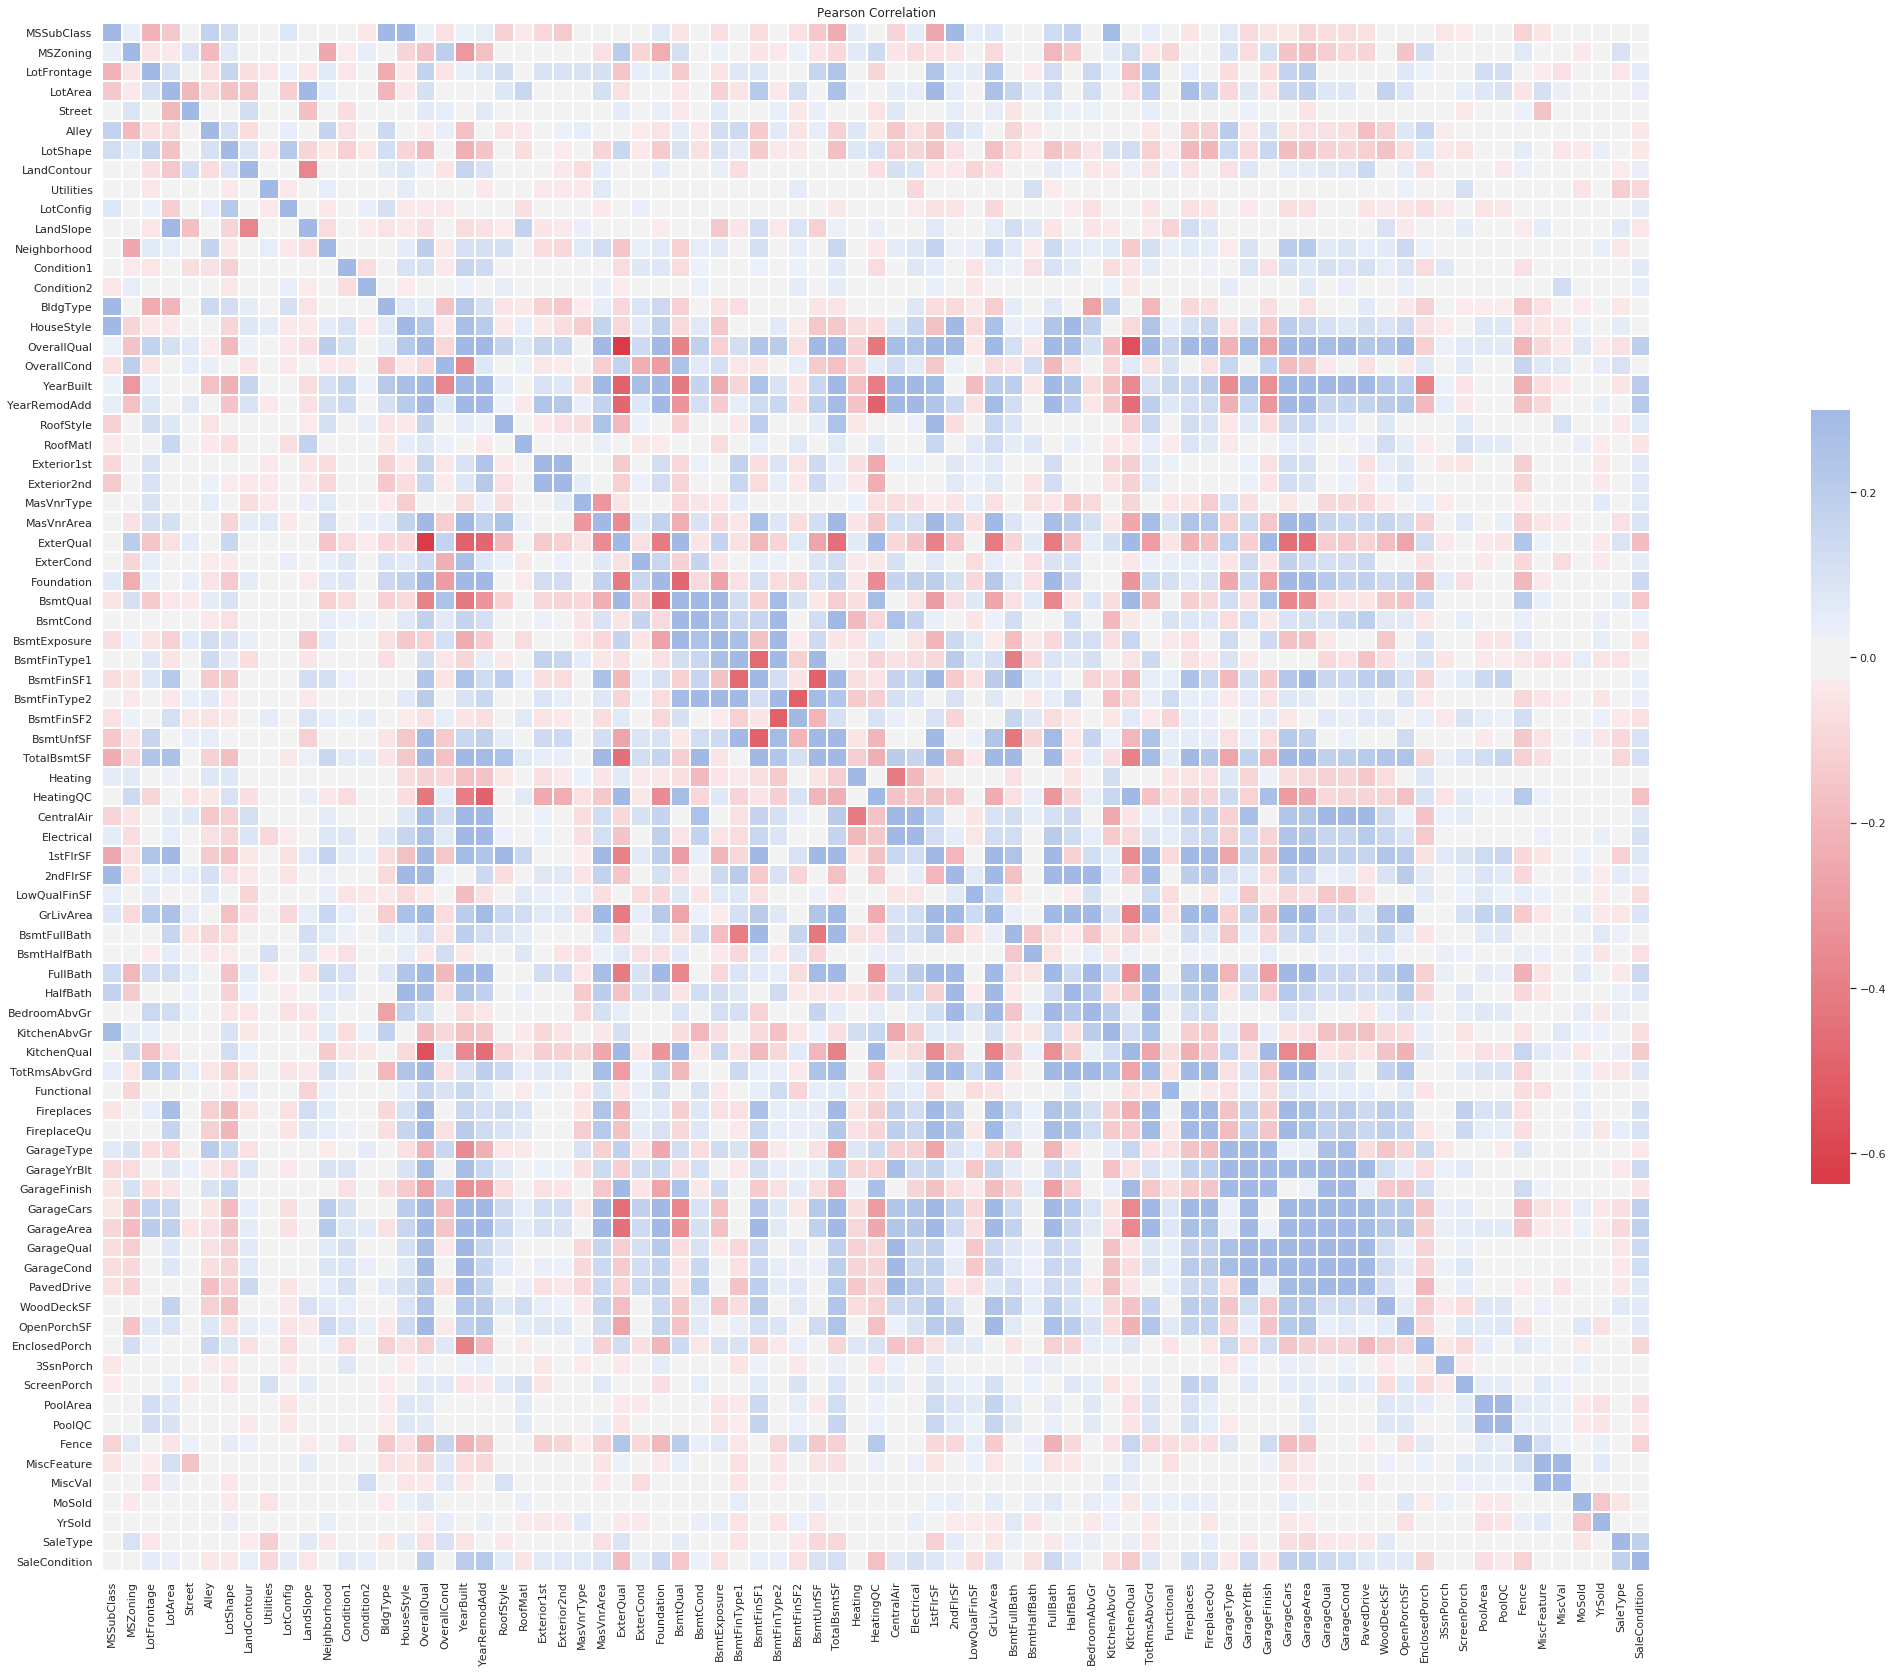

In [7]:
concat = np.c_[df_train.to_numpy(), y_train.reshape(len(y_train), 1)]
df = pd.DataFrame(concat, columns=list(df_train.columns) + ["Label"]).astype(np.float64)
corr = df.corr()
cmap = sns.diverging_palette(10, 255, as_cmap=True)

plt.figure(figsize=(45, 45))
plt.subplot(2, 1, 1)
plt.title("Pearson Correlation")
ax = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, annot=False, cbar_kws={"shrink": .5})
ax.set_ylim(size, 0)
ax.set_xlim(0, size)
plt.tight_layout()
plt.show()

Let's do some PCA to see the energy of each column...

In [8]:
columns = df_train.columns
columns = columns[tuple(np.where(columns != "Label"))]
pca = PCA(n_components=len(columns))
pca.fit(df_train[columns])

print("PCA (Principal component analysis):")
print("Singular Values:")
print(np.round(pca.singular_values_, 5))

PCA (Principal component analysis):
Singular Values:
[3.81367940e+05 2.74310309e+04 2.23842242e+04 2.02724979e+04
 1.88857547e+04 1.70553525e+04 8.59747029e+03 6.73760120e+03
 6.16977844e+03 5.20434489e+03 4.52558274e+03 2.46296821e+03
 2.21930868e+03 2.11433853e+03 2.02089655e+03 1.53660354e+03
 1.49294284e+03 1.17299100e+03 1.11210588e+03 9.37414270e+02
 5.47357380e+02 2.23263570e+02 1.63822310e+02 1.03099370e+02
 7.37434800e+01 6.38212900e+01 6.09265500e+01 5.92455500e+01
 5.62920300e+01 5.48455700e+01 5.18880300e+01 4.99686100e+01
 4.85652200e+01 4.66986000e+01 4.60274600e+01 4.04730900e+01
 3.89617600e+01 3.80043500e+01 3.64719600e+01 3.52404000e+01
 3.35336600e+01 3.22306600e+01 3.13667700e+01 3.05973600e+01
 2.84235100e+01 2.74632700e+01 2.59639000e+01 2.42485500e+01
 2.32476200e+01 2.24919800e+01 2.19821100e+01 2.17943100e+01
 2.15612100e+01 2.11743600e+01 2.05734100e+01 2.03602300e+01
 1.91639200e+01 1.84332300e+01 1.80737100e+01 1.56105000e+01
 1.54120500e+01 1.51439600e+01 1

Remove columns that have low correlation with the final price.

In [9]:
columns = list(df.columns[corr["Label"].ravel() > 0.05].ravel())
columns += list(df.columns[corr["Label"].ravel() < -0.05].ravel())
columns = np.array(sorted(columns))
columns = columns[tuple(np.where(columns != "Label"))]
print("Columns with strong linear correlation:")
print(len(columns))
print(columns)

Columns with strong linear correlation:
66
['1stFlrSF' '2ndFlrSF' 'Alley' 'BedroomAbvGr' 'BldgType' 'BsmtCond'
 'BsmtExposure' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFullBath' 'BsmtQual'
 'BsmtUnfSF' 'CentralAir' 'Condition1' 'Electrical' 'EnclosedPorch'
 'ExterCond' 'ExterQual' 'Exterior1st' 'Exterior2nd' 'Fence' 'FireplaceQu'
 'Fireplaces' 'Foundation' 'FullBath' 'Functional' 'GarageArea'
 'GarageCars' 'GarageCond' 'GarageFinish' 'GarageQual' 'GarageType'
 'GarageYrBlt' 'GrLivArea' 'HalfBath' 'Heating' 'HeatingQC' 'HouseStyle'
 'KitchenAbvGr' 'KitchenQual' 'LandSlope' 'LotArea' 'LotConfig'
 'LotFrontage' 'LotShape' 'MSSubClass' 'MSZoning' 'MasVnrArea'
 'MiscFeature' 'Neighborhood' 'OpenPorchSF' 'OverallCond' 'OverallQual'
 'PavedDrive' 'PoolArea' 'PoolQC' 'RoofMatl' 'RoofStyle' 'SaleCondition'
 'SaleType' 'ScreenPorch' 'TotRmsAbvGrd' 'TotalBsmtSF' 'WoodDeckSF'
 'YearBuilt' 'YearRemodAdd']


Let's apply PCA on those new selected columns to see if we still have lot's of energy.

In [10]:
pca = PCA(n_components=len(columns))
pca.fit(df_train[columns])

print("PCA (Principal component analysis):")
print("Singular Values:")
print(np.round(pca.singular_values_, 5))

PCA (Principal component analysis):
Singular Values:
[3.81366642e+05 2.74203040e+04 2.23699224e+04 2.02399697e+04
 1.70522756e+04 8.31770692e+03 6.26575312e+03 5.20810897e+03
 4.54940558e+03 3.42072217e+03 2.46089238e+03 2.21793694e+03
 2.04735089e+03 1.53592936e+03 1.49733432e+03 1.17837248e+03
 1.06667162e+03 9.12785590e+02 5.47458070e+02 2.23313030e+02
 1.63907580e+02 7.36801700e+01 6.38198000e+01 5.98579500e+01
 5.90098800e+01 5.50144700e+01 5.19352700e+01 4.96331900e+01
 4.76730900e+01 4.62793500e+01 4.07623700e+01 3.89594300e+01
 3.85950900e+01 3.66513200e+01 3.54381600e+01 3.36516500e+01
 3.26931600e+01 3.15047800e+01 3.07106300e+01 2.84887100e+01
 2.74682900e+01 2.43505800e+01 2.38504400e+01 2.25218600e+01
 2.18882200e+01 2.17751700e+01 2.14025700e+01 2.10085100e+01
 2.05956100e+01 1.98229400e+01 1.86748700e+01 1.81050800e+01
 1.56370900e+01 1.55167300e+01 1.52007700e+01 1.38619300e+01
 1.38374300e+01 1.23482300e+01 1.16978400e+01 1.16317900e+01
 1.06093300e+01 9.96270000e+00 8

Given the above, let's run our Regressors on the Correlation and on small dataset using PCA...

In [11]:
pX_train, pX_test, py_train, py_test = train_test_split(df_train[columns], y_train, test_size=0.33, random_state=42)

In [12]:
print("Random Forest Regression:")
md = RandomForestRegressor(**{
    'criterion': 'mse',
    'max_features': 'auto',
    'max_leaf_nodes': 500,
    'n_estimators': 500,
    'n_jobs': 4,
    'random_state': 42
})
md.fit(pX_train, py_train)
y_pred = md.predict(pX_test)
print(f"R^2: {md.score(pX_test, py_test)}")
print(f"RMSE: {rmse(py_test, y_pred)}")
print(f"RMSLE: {rmsle(py_test, y_pred)}")
print(f"Log MSE: {mean_squared_log_error(py_test, y_pred)}")
print(f"MAE: {mean_absolute_error(py_test, y_pred)}")

Random Forest Regression:
R^2: 0.8685312487201434
RMSE: 31067.081530678977
RMSLE: 0.14476696421621146
Log MSE: 0.02095747392837785
MAE: 17483.503371355488


In [13]:
# print("MLP Regression:")
# md = MLPRegressor(**{
#     "hidden_layer_sizes": (100, 10),
#     "learning_rate": "constant",
#     "learning_rate_init": 1e-3,
#     "activation": "relu",
#     "alpha": 1e-2,
#     "batch_size": 32,
#     "solver": "lbfgs",
#     "max_iter": 500,
#     "random_state": 42
# })
# md.fit(pX_train, py_train)
# y_pred = md.predict(pX_test)
# print(f"R^2: {md.score(pX_test, py_test)}")
# print(f"RMSE: {rmse(py_test, y_pred)}")
# print(f"RMSLE: {rmsle(py_test, y_pred)}")
# print(f"Log MSE: {mean_squared_log_error(py_test, y_pred)}")
# print(f"MAE: {mean_absolute_error(py_test, y_pred)}")

In [14]:
pca = PCA(n_components=30)
x_pca = pca.fit_transform(df_train[columns])
print("PCA (Principal component analysis):")
print("Singular Values:")
print(np.round(pca.singular_values_, 5))

pX_train, pX_test, py_train, py_test = train_test_split(x_pca, y_train, test_size=0.33, random_state=42)

PCA (Principal component analysis):
Singular Values:
[3.81366642e+05 2.74203040e+04 2.23699224e+04 2.02399697e+04
 1.70522756e+04 8.31770692e+03 6.26575312e+03 5.20810897e+03
 4.54940558e+03 3.42072217e+03 2.46089238e+03 2.21793694e+03
 2.04735089e+03 1.53592936e+03 1.49733432e+03 1.17837248e+03
 1.06667162e+03 9.12785590e+02 5.47458070e+02 2.23313030e+02
 1.63907580e+02 7.36801700e+01 6.38198000e+01 5.98579400e+01
 5.90098600e+01 5.50143800e+01 5.19352100e+01 4.96331300e+01
 4.76730200e+01 4.62777900e+01]


In [15]:
print("Random Forest Regression:")
md = RandomForestRegressor(**{
    'criterion': 'mse',
    'max_features': 'auto',
    'max_leaf_nodes': 500,
    'n_estimators': 500,
    'n_jobs': 4,
    'random_state': 42
})
md.fit(pX_train, py_train)
y_pred = md.predict(pX_test)
print(f"R^2: {md.score(pX_test, py_test)}")
print(f"RMSE: {rmse(py_test, y_pred)}")
print(f"RMSLE: {rmsle(py_test, y_pred)}")
print(f"Log MSE: {mean_squared_log_error(py_test, y_pred)}")
print(f"MAE: {mean_absolute_error(py_test, y_pred)}")

Random Forest Regression:
R^2: 0.7616827152536504
RMSE: 41827.98650803994
RMSLE: 0.1803523318735345
Log MSE: 0.03252696361222153
MAE: 22792.45928694308


In [16]:
# print("MLP Regression:")
# md = MLPRegressor(**{
#     "hidden_layer_sizes": (100, 10),
#     "learning_rate": "constant",
#     "learning_rate_init": 1e-3,
#     "activation": "relu",
#     "alpha": 1e-4,
#     "batch_size": 32,
#     "solver": "lbfgs",
#     "max_iter": 500,
#     "random_state": 42
# })
# md.fit(pX_train, py_train)
# y_pred = md.predict(pX_test)
# print(f"R^2: {md.score(pX_test, py_test)}")
# print(f"RMSE: {rmse(py_test, y_pred)}")
# print(f"RMSLE: {rmsle(py_test, y_pred)}")
# print(f"Log MSE: {mean_squared_log_error(py_test, y_pred)}")
# print(f"MAE: {mean_absolute_error(py_test, y_pred)}")

In [17]:
md = RandomForestRegressor(**{
    'criterion': 'mse',
    'max_features': 'auto',
    'max_leaf_nodes': 500,
    'n_estimators': 2500,
    'n_jobs': 4,
    'random_state': 42
})
md.fit(df_train[columns], y_train)
y_pred = np.round(md.predict(df_test[columns]).ravel(), 3)

# md = MLPRegressor(**{
#     "hidden_layer_sizes": (200, 5),
#     "learning_rate": "adaptive",
#     "learning_rate_init": 1e-1,
#     "activation": "relu",
#     "alpha": 1e-5,
#     "batch_size": 32,
#     "solver": "lbfgs",
#     "max_iter": 2000,
#     "random_state": 42
# })
# md.fit(x_pca, y_train)
# y_pred = np.round(md.predict(t_pca).ravel(), 3)

i_df_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
sub = pd.DataFrame()
sub["Id"] = i_df_test["Id"]
sub["SalePrice"] = y_pred.astype(np.int)
sub.to_csv('submission.csv', index=False)